In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as Data

from torchtext import data
from torchtext.vocab import Vectors
from torchtext.data import Iterator, BucketIterator

import pandas as pd
import numpy as np

import re
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
# 定义超参数
LR = 0.001
EPOCHS = 128
OUT_NUM = 4
BATCH_SIZE = 1

HIDDEN_NUM = 256

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
polarity2num = {'positive':0, 'negative':1, 'neutral':2, 'conflict':3}

In [3]:
# 按照paper预处理数据，构建dataset
def data_process(df, text_field, label_field):
    texts = df.text.apply(lambda x: re.findall(r'\b\w+\b',x)).values.tolist()
    targets = df.term.apply(lambda x: re.findall(r'\b\w+\b',x)).values.tolist()
    idxs_l = [texts[i].index(targets[i][0]) for i in range(len(texts))]
    idxs_r = [texts[i].index(targets[i][-1]) for i in range(len(texts))]
    contexts = [' '.join(texts[i][:idxs_l[i]]+texts[i][idxs_r[i]+1:]) for i in range(len(texts))]
    
    for pol in polarity2num:
        df.polarity = df.polarity.replace(pol, polarity2num[pol])
    labels = df.polarity
    
    fields = [("context", text_field), ("target", text_field), ("label", label_field)]       
    examples = []
    for context, target, label in tqdm(zip(contexts, targets, labels)):
        examples.append(data.Example.fromlist([context, target, label], fields))
    
    dataset = data.Dataset(examples, fields)
    return dataset

In [4]:
# 定义IAN模型
class IAN(nn.Module):
    def __init__(self, weight_matrix):
        super(IAN, self).__init__()
        self.embedding = nn.Embedding(weight_matrix.shape[0], weight_matrix.shape[1])  
        self.embedding.weight.data.copy_(weight_matrix)
        
        self.lstm_context = nn.LSTM(input_size=weight_matrix.shape[1], hidden_size=HIDDEN_NUM)
        self.lstm_target = nn.LSTM(input_size=weight_matrix.shape[1], hidden_size=HIDDEN_NUM)
        self.attention_context = nn.Linear(HIDDEN_NUM*2, 1)
        self.attention_target = nn.Linear(HIDDEN_NUM*2, 1)

        self.out = nn.Linear(HIDDEN_NUM*2, OUT_NUM)

    def forward(self, X):
        context = self.embedding(X[0])
        target = self.embedding(X[1])
        
        n = context.shape[0]
        batch_size = context.shape[1]
        d = context.shape[2]
        
        hidden_state_context = torch.randn(1, batch_size, HIDDEN_NUM).to(DEVICE)
        cell_state_context = torch.randn(1, batch_size, HIDDEN_NUM).to(DEVICE)
        hidden_state_target = torch.randn(1, batch_size, HIDDEN_NUM).to(DEVICE)
        cell_state_target = torch.randn(1, batch_size, HIDDEN_NUM).to(DEVICE)
        
        context, (_, _) = self.lstm_context(context, (hidden_state_context, cell_state_context))
        target, (_, _) = self.lstm_target(target, (hidden_state_context, cell_state_context))
        
        context_pool = target = torch.mean(context, dim=0, keepdim=True)
        target_pool = target = torch.mean(target, dim=0, keepdim=True)
        
        context_input = torch.cat((context ,torch.cat(([target_pool] * n))), dim=2)
        context_score = F.softmax(torch.tanh(self.attention_context(context_input)).transpose(0, 1), dim=1)
        context_final = torch.bmm(context.transpose(0, 1).transpose(1, 2), context_score).transpose(1, 2).transpose(0, 1)
        
        target_input = torch.cat((target, torch.cat(([context_pool]))), dim=2)
        target_score = F.softmax(torch.tanh(self.attention_target(target_input)).transpose(0, 1), dim=1)
        target_final = torch.bmm(target.transpose(0, 1).transpose(1, 2), target_score).transpose(1, 2).transpose(0, 1)
        
        final = torch.cat((context_final, target_final), dim=2)
        out = torch.tanh(self.out(final.squeeze(dim=0)))
        
        return out

In [5]:
# 计算正确率
def get_acc(model, trial_iter):
    pred, real = [], []
    for batch in trial_iter:
        pred.extend(model([batch.context.to(DEVICE), batch.target.to(DEVICE)]).data.max(1, keepdim=True)[1].tolist())
        real.extend(batch.label.data.tolist())
    accuracy = accuracy_score(pred, real)  
    return accuracy

In [6]:
# 构造数据
df_train = pd.read_csv('../input/semeval-14-restaurant-review/restaurant_train_term.csv')
df_trial = pd.read_csv('../input/semeval-14-restaurant-review/restaurant_trial_term.csv')

tokenize = lambda x: x.split()
TEXT = data.Field(sequential=True, lower=True, tokenize=tokenize)
LABEL = data.Field(sequential=False, use_vocab=False)

dataset_train = data_process(df_train, TEXT, LABEL)
dataset_trial = data_process(df_trial, TEXT, LABEL)
dataset = data_process(pd.concat([df_trial, df_train], axis=0, ignore_index=True), TEXT, LABEL)

train_iter, trial_iter = BucketIterator.splits(
        (dataset_train, dataset_trial),
        batch_sizes=(BATCH_SIZE, BATCH_SIZE),
        device = DEVICE, 
        sort_key=lambda x: len(x.context),
        sort_within_batch=False,
        repeat=False 
)

3324it [00:00, 53239.04it/s]
369it [00:00, 59151.47it/s]
3693it [00:00, 52708.90it/s]


In [7]:
# 加载词向量
vectors = Vectors(name='../input/glove840b300dtxt/glove.840B.300d.txt')
TEXT.build_vocab(dataset, vectors=vectors)
weight_matrix = TEXT.vocab.vectors

100%|█████████▉| 2196017/2196018 [05:12<00:00, 7025.18it/s]


In [8]:
# 构造模型
model = IAN(weight_matrix).to(DEVICE)
criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor([1, 2.68, 3.42, 23.74])).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR)

In [9]:
# 训练模型
los, acc = [], []
for epoch in tqdm(range(EPOCHS)):
    for step, batch in enumerate(train_iter):
        pred = model([batch.context.to(DEVICE), batch.target.to(DEVICE)])
        loss = criterion(pred, batch.label.to(DEVICE))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    los.append(loss)
    acc.append(get_acc(model, trial_iter))

100%|██████████| 128/128 [39:36<00:00, 18.57s/it]


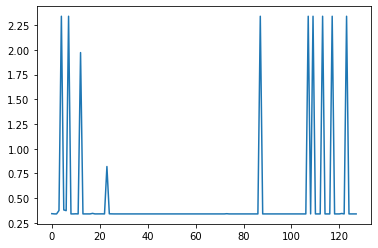

In [10]:
# 可视化
plt.plot(los)

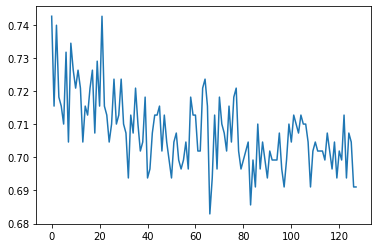

In [11]:
plt.plot(acc)